In [1]:
import json
import random
import numpy as np
import math

# ================================
# 1) AUGMENTATION FUNCTION
# ================================

def augment_tsp_instance(instance):
    coords = np.array(instance["coords"], dtype=float)
    tour = list(instance["tour"])

    # --- 1. Random rotation ---
    theta = random.uniform(0, 2*np.pi)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array([[c, -s],
                  [s,  c]])
    coords = coords @ R.T

    # --- 2. Random flips ---
    if random.random() < 0.5:
        coords[:, 0] = -coords[:, 0]
    if random.random() < 0.5:
        coords[:, 1] = -coords[:, 1]

    # --- 3. Small uniform scale ---
    scale = random.uniform(0.9, 1.1)
    coords = coords * scale

    # --- 4. Random translation ---
    tx = random.uniform(-500, 500)
    ty = random.uniform(-500, 500)
    coords[:, 0] += tx
    coords[:, 1] += ty

    # --- 5. Circular shift in tour ---
    shift = random.randint(0, len(tour)-1)
    tour = tour[shift:] + tour[:shift]

    # --- 6. Reverse tour with prob 0.5 ---
    if random.random() < 0.5:
        tour = list(reversed(tour))

    return {
        "coords": coords.tolist(),
        "tour": tour,
        "gap": instance.get("gap", 0.0)
    }


# ================================
# 2) LOAD JSON AND GROUP BY SIZE
# ================================

def load_and_group_by_N(filename):
    with open(filename, "r") as f:
        data = json.load(f)

    groups = {}  # N -> list of instances

    for inst in data:
        N = len(inst["coords"])
        if N not in groups:
            groups[N] = []
        groups[N].append(inst)

    return groups


# ================================
# 3) CREATE NEW DATASET BASED ON TARGET DISTRIBUTION
# ================================

def build_augmented_dataset(groups, target_distribution):
    new_dataset = []

    for N, target_count in target_distribution.items():
        if N not in groups:
            print(f"[WARN] No instances of N={N} in input dataset.")
            continue

        base_instances = groups[N]
        base_len = len(base_instances)

        print(f"\n--- N={N} ---")
        print(f"Temos {base_len} instâncias originais, queremos {target_count}")

        if base_len >= target_count:
            # only sample randomly without augmentation
            print("→ Já temos o suficiente, apenas amostrando.")
            selected = random.sample(base_instances, target_count)
            new_dataset.extend(selected)
            continue

        # Add originals first
        new_dataset.extend(base_instances)
        remaining = target_count - base_len

        print(f"→ Precisamos gerar {remaining} augmentations.")

        # Generate augmentations
        for _ in range(remaining):
            base_inst = random.choice(base_instances)
            aug_inst = augment_tsp_instance(base_inst)
            new_dataset.append(aug_inst)

    return new_dataset


# ================================
# 4) MAIN FUNCTION
# ================================

def generate_augmented_json(
    input_json="euc_2d_train.json",
    output_json="euc_2d_train_augmented.json",
    target_distribution=None
):
    print("Carregando dataset...")
    groups = load_and_group_by_N(input_json)

    print("Construindo dataset aumentado...")
    new_dataset = build_augmented_dataset(groups, target_distribution)

    print(f"\nSalvando {len(new_dataset)} instâncias em {output_json}...")
    with open(output_json, "w") as f:
        json.dump(new_dataset, f, indent=2)

    print("Pronto!")


# ================================
# 5) EXAMPLE USAGE
# ================================


TARGET_DISTRIBUTION = {
    10: 1000,
    20: 1200,
    30: 1400,
    40: 1600,
    50: 1800,
    60: 2000,
    70: 2200,
    80: 2400,
    90: 2600,
    100: 2800
}


INPUT_PATH = './data/new-generated/euc_2d_train.json'
AUGMENTED_PATH = "./data/new-generated/euc_2d_train_aug.json"


generate_augmented_json(INPUT_PATH,
                        AUGMENTED_PATH,
                        TARGET_DISTRIBUTION)


Carregando dataset...
Construindo dataset aumentado...

--- N=10 ---
Temos 908 instâncias originais, queremos 1000
→ Precisamos gerar 92 augmentations.

--- N=20 ---
Temos 878 instâncias originais, queremos 1200
→ Precisamos gerar 322 augmentations.

--- N=30 ---
Temos 901 instâncias originais, queremos 1400
→ Precisamos gerar 499 augmentations.

--- N=40 ---
Temos 897 instâncias originais, queremos 1600
→ Precisamos gerar 703 augmentations.

--- N=50 ---
Temos 865 instâncias originais, queremos 1800
→ Precisamos gerar 935 augmentations.

--- N=60 ---
Temos 899 instâncias originais, queremos 2000
→ Precisamos gerar 1101 augmentations.

--- N=70 ---
Temos 863 instâncias originais, queremos 2200
→ Precisamos gerar 1337 augmentations.

--- N=80 ---
Temos 892 instâncias originais, queremos 2400
→ Precisamos gerar 1508 augmentations.

--- N=90 ---
Temos 884 instâncias originais, queremos 2600
→ Precisamos gerar 1716 augmentations.

--- N=100 ---
Temos 901 instâncias originais, queremos 2800

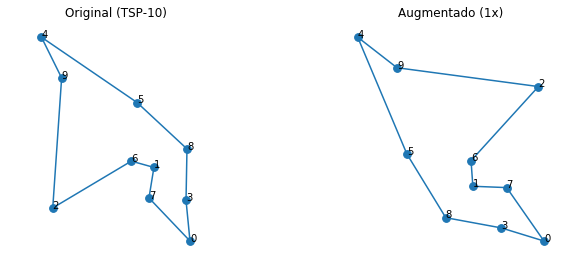

In [9]:
import json
import random
import numpy as np
import matplotlib.pyplot as plt

# ------------ plot helper ------------
def plot_tsp(instance, ax, title):
    coords = np.array(instance["coords"])
    tour = instance["tour"]

    ax.scatter(coords[:, 0], coords[:, 1], s=60)

    path = coords[tour + [tour[0]]]
    ax.plot(path[:, 0], path[:, 1], "-o")

    for i, (x, y) in enumerate(coords):
        ax.text(x, y, str(i), fontsize=10)

    ax.set_title(title)
    ax.set_aspect("equal")
    ax.axis("off")


# ------------ load data ------------
with open(INPUT_PATH, "r") as f:
    data = json.load(f)

# pega um TSP-10
base = random.choice([d for d in data if len(d["coords"]) == 10])

# gera UMA augmentação
aug = augment_tsp_instance(base)

# ------------ plot ------------
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

plot_tsp(base, ax[0], "Original (TSP-10)")
plot_tsp(aug, ax[1], "Augmentado (1x)")

plt.tight_layout()
plt.show()
